# Merged Multimodal Preprocessing Pipeline
## Combining Advanced Feature Engineering with Image Synchronization

This notebook merges the strengths of two previous pipelines:
1. **Image Synchronization** (from `preprocessing.ipynb`): Ensures every tabular data row has a corresponding satellite image on disk.
2. **Advanced Feature Engineering** (from `preprocessing_csv_updated.ipynb`): Adds spatial, temporal, and polynomial features to boost model performance.

**Output:** saved to `processed_data/`
* `X_train.csv`, `X_test.csv`: Scaled features.
* `y_train.csv`, `meta_train.csv`: Targets and Image Paths.
* `scaler.pkl`: For inference.

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import pickle
import logging
import warnings

warnings.filterwarnings('ignore')

# Setup Logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# CONFIGURATION
IMAGE_DIR = "satellite_images"
OUTPUT_DIR = "processed_data"
TRAIN_PATH = "train.csv"
TEST_PATH = "test.csv"
EDA_DIR = "visualizations"

if not os.path.exists(EDA_DIR):
    os.makedirs(EDA_DIR)

### 1. Load and Sync Data
First, we load the data and ensure we only keep rows that have downloaded satellite images.

In [3]:
def load_and_sync_data(train_path, test_path, image_dir):
    logger.info(f"Loading data from {train_path} and {test_path}...")
    
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    
    # --- Create Image Paths ---
    train_df['image_path'] = train_df['id'].apply(lambda x: os.path.join(image_dir, f"{x}.jpg"))
    test_df['image_path'] = test_df['id'].apply(lambda x: os.path.join(image_dir, f"{x}.jpg"))
    
    # --- Verify Existence ---
    logger.info("Verifying image files on disk...")
    train_df['has_image'] = train_df['image_path'].apply(os.path.exists)
    
    # Filter Training Data
    train_clean = train_df[train_df['has_image'] == True].copy()
    dropped = len(train_df) - len(train_clean)
    logger.info(f"✓ Training Data Synced: Kept {len(train_clean)} rows (Dropped {dropped} rows missing images).")
    
    # For test data, we usually keep all, or handle missing images carefully. 
    # Here we won't filter test DF by image existence for submission purposes, 
    # but for local evaluation you might want to.
    
    return train_clean.drop(columns=['has_image']), test_df

train_df, test_df = load_and_sync_data(TRAIN_PATH, TEST_PATH, IMAGE_DIR)

2026-01-07 08:50:33,275 - INFO - Loading data from train.csv and test.csv...
2026-01-07 08:50:33,454 - INFO - Verifying image files on disk...
2026-01-07 08:50:34,436 - INFO - ✓ Training Data Synced: Kept 16209 rows (Dropped 0 rows missing images).


### 2. Data Cleaning
Basic cleaning steps from the updated pipeline.

In [4]:
def clean_data(df):
    df = df.copy()
    # Determine numeric columns for median filling
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].median(), inplace=True)
    return df

train_df = clean_data(train_df)
test_df = clean_data(test_df)

### 3. Advanced Feature Engineering
Incorporating the rich feature set including spatial, temporal, and interaction terms.

In [5]:
def engineer_features(df):
    df = df.copy()
    
    # 1. Temporal Features
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
        df['year'] = df['date'].dt.year
        df['month'] = df['date'].dt.month
        df['quarter'] = df['date'].dt.quarter
        df['season'] = df['month'].apply(
            lambda x: 1 if x in [12, 1, 2] else
                      2 if x in [3, 4, 5] else
                      3 if x in [6, 7, 8] else 4
        )
        # We drop date later or keep it for reference, but usually drop for model
    
    # 2. Spatial Features (Seattle Center)
    if 'lat' in df.columns and 'long' in df.columns:
        seattle_lat, seattle_long = 47.6062, -122.3321
        df['distance_from_center'] = np.sqrt(
            (df['lat'] - seattle_lat)**2 + (df['long'] - seattle_long)**2
        )
        df['lat_squared'] = df['lat']**2
        df['long_squared'] = df['long']**2
        df['lat_long_interaction'] = df['lat'] * df['long']

    # 3. Area Features
    if 'sqft_living' in df.columns:
        df['log_sqft_living'] = np.log1p(df['sqft_living'])
        df['sqft_per_lot'] = df['sqft_living'] / (df['sqft_lot'] + 1)
        df['living_to_above_ratio'] = df['sqft_living'] / (df['sqft_above'] + 1)
        df['basement_to_living_ratio'] = df['sqft_basement'] / (df['sqft_living'] + 1)

    # 4. Neighborhood Features
    if 'sqft_living15' in df.columns and 'sqft_living' in df.columns:
        df['living_vs_neighborhood'] = df['sqft_living'] / (df['sqft_living15'] + 1)
    if 'sqft_lot15' in df.columns and 'sqft_lot' in df.columns:
        df['lot_vs_neighborhood'] = df['sqft_lot'] / (df['sqft_lot15'] + 1)

    # 5. Property Condition / Grade
    if 'condition' in df.columns:
        df['is_excellent_condition'] = (df['condition'] >= 4).astype(int)
        df['is_poor_condition'] = (df['condition'] <= 2).astype(int)
    if 'grade' in df.columns:
        df['is_high_grade'] = (df['grade'] >= 11).astype(int)
        df['is_low_grade'] = (df['grade'] <= 6).astype(int)
        df['grade_squared'] = df['grade']**2

    # 6. Binary Flags
    if 'view' in df.columns:
        df['has_view'] = (df['view'] > 0).astype(int)
    if 'waterfront' in df.columns:
        df['is_waterfront'] = df['waterfront'].astype(int)
    if 'sqft_basement' in df.columns:
        df['has_basement'] = (df['sqft_basement'] > 0).astype(int)
    if 'floors' in df.columns:
        df['multi_level'] = (df['floors'] > 1).astype(int)

    # 7. Rooms
    if 'bedrooms' in df.columns and 'bathrooms' in df.columns:
        df['total_rooms'] = df['bedrooms'] + df['bathrooms']
        df['bed_bath_ratio'] = df['bedrooms'] / (df['bathrooms'] + 1)

    # 8. Age
    if 'yr_built' in df.columns:
        df['age'] = 2015 - df['yr_built']
        df['age_squared'] = df['age']**2
    if 'yr_renovated' in df.columns:
        df['was_renovated'] = (df['yr_renovated'] > 0).astype(int)
        df['years_since_renovation'] = df.apply(lambda row: 2015 - row['yr_renovated'] if row['yr_renovated'] > 0 else 0, axis=1)

    # Drop non-numeric for final Feature Set
    # Note: We keep 'id' and 'image_path' for alignment but will drop them from X
    drop_cols = ['date', 'zipcode'] # Dropping zipcode as in original preprocessing, can be debated
    df = df.drop(columns=[c for c in drop_cols if c in df.columns])
    
    return df

logger.info("Engineering features...")
train_df = engineer_features(train_df)
test_df = engineer_features(test_df)

2026-01-07 08:50:55,074 - INFO - Engineering features...


### 4. Exploratory Data Analysis (EDA)
Generating statistical summaries and visualizations.  
**Plots Saved to:** `visualizations/`

In [6]:
# ============================================================================
# 4. EXPLORATORY DATA ANALYSIS (EDA)
# ============================================================================

import os

os.makedirs(EDA_DIR, exist_ok=True)

# 4.1 Price Distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_df['price'], kde=True, bins=50)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.savefig(os.path.join(EDA_DIR, 'eda_price_dist.png'))
plt.close()
logger.info("Saved Price Distribution plot.")

# 4.2 Log-Price Distribution
plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(train_df['price']), kde=True, bins=50)
plt.title('Log(Price) Distribution')
plt.xlabel('Log Price')
plt.savefig(os.path.join(EDA_DIR, 'eda_log_price_dist.png'))
plt.close()
logger.info("Saved Log-Price Distribution plot.")

# 4.3 Correlation Heatmap (numeric only)
numeric_train = train_df.select_dtypes(include=[np.number])
corr = numeric_train.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title('Correlation Matrix of Numeric Features')
plt.savefig(os.path.join(EDA_DIR, 'eda_correlation.png'))
plt.close()
logger.info("Saved Correlation Heatmap.")

# 4.4 Living Area vs Price
if 'sqft_living' in train_df.columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=train_df, x='sqft_living', y='price', alpha=0.5)
    plt.title('Living Area vs Price')
    plt.xlabel('Sqft Living')
    plt.ylabel('Price')
    plt.savefig(os.path.join(EDA_DIR, 'eda_sqft_vs_price.png'))
    plt.close()
    logger.info("Saved Sqft vs Price scatter plot.")

# 4.5 Grade vs Price
if 'grade' in train_df.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=train_df, x='grade', y='price')
    plt.title('Grade vs Price')
    plt.savefig(os.path.join(EDA_DIR, 'eda_grade_vs_price.png'))
    plt.close()
    logger.info("Saved Grade vs Price box plot.")

# 4.6 Geospatial Price Map
if {'lat', 'long'}.issubset(train_df.columns):
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        data=train_df,
        x='long',
        y='lat',
        hue='price',
        size='price',
        palette='viridis',
        sizes=(10, 200),
        alpha=0.6,
        legend=False
    )
    plt.title('Geospatial Distribution of Prices')
    plt.savefig(os.path.join(EDA_DIR, 'eda_geo_price.png'))
    plt.close()
    logger.info("Saved Geospatial Price plot.")

# 4.7 Categorical Feature Analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

if 'condition' in train_df.columns:
    train_df.boxplot(column='price', by='condition', ax=axes[0, 0])
    axes[0, 0].set_title('Price by Condition')
    axes[0, 0].set_xlabel('Condition')
    axes[0, 0].set_ylabel('Price')

if 'grade' in train_df.columns:
    train_df.boxplot(column='price', by='grade', ax=axes[0, 1])
    axes[0, 1].set_title('Price by Grade')
    axes[0, 1].set_xlabel('Grade')
    axes[0, 1].set_ylabel('Price')

if 'view' in train_df.columns:
    train_df.boxplot(column='price', by='view', ax=axes[1, 0])
    axes[1, 0].set_title('Price by View')
    axes[1, 0].set_xlabel('View')
    axes[1, 0].set_ylabel('Price')

if 'waterfront' in train_df.columns:
    train_df.boxplot(column='price', by='waterfront', ax=axes[1, 1])
    axes[1, 1].set_title('Price by Waterfront')
    axes[1, 1].set_xlabel('Waterfront (0 = No, 1 = Yes)')
    axes[1, 1].set_ylabel('Price')

plt.suptitle('')
plt.tight_layout()
plt.savefig(os.path.join(EDA_DIR, 'eda_categorical_analysis.png'), dpi=120, bbox_inches='tight')
plt.close()
logger.info("Saved categorical feature analysis plots.")


2026-01-07 08:51:00,787 - INFO - Saved Price Distribution plot.
2026-01-07 08:51:01,373 - INFO - Saved Log-Price Distribution plot.
2026-01-07 08:51:02,603 - INFO - Saved Correlation Heatmap.
2026-01-07 08:51:02,962 - INFO - Saved Sqft vs Price scatter plot.
2026-01-07 08:51:02,999 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2026-01-07 08:51:03,016 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2026-01-07 08:51:03,273 - INFO - Saved Grade vs Price box plot.
2026-01-07 08:51:04,696 - INFO - Saved Geospatial Price plot.
2026-01-07 08:51:06,159 - INFO - Saved categorical feature analysis plots.


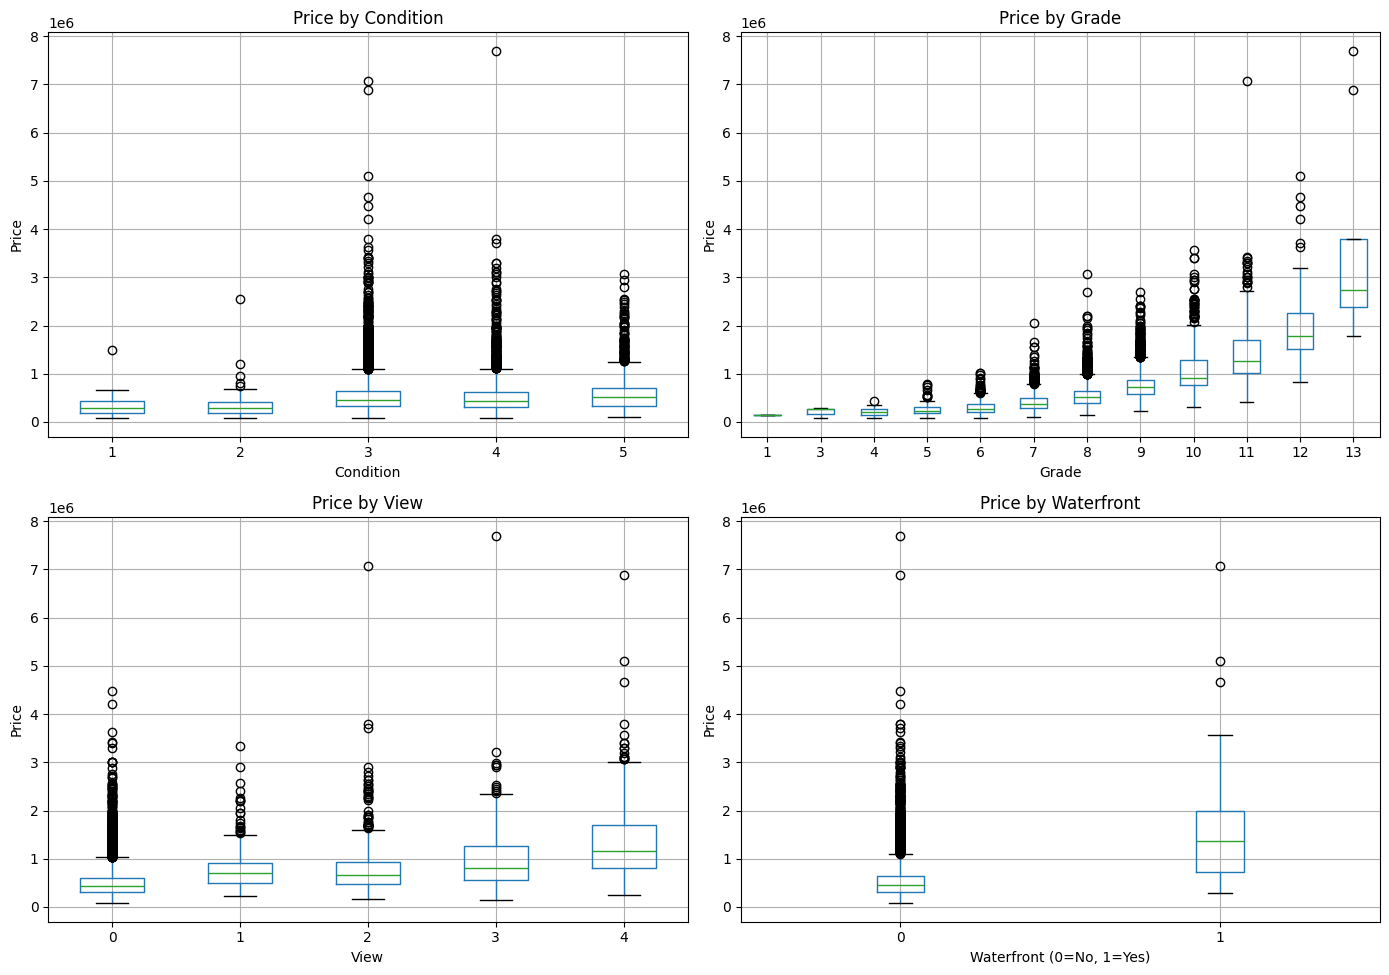

In [7]:
# Feature distributions by categorical variables
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Condition vs Price
train_df.boxplot(column='price', by='condition', ax=axes[0, 0])
axes[0, 0].set_title('Price by Condition')
axes[0, 0].set_xlabel('Condition')
axes[0, 0].set_ylabel('Price')

# Grade vs Price
train_df.boxplot(column='price', by='grade', ax=axes[0, 1])
axes[0, 1].set_title('Price by Grade')
axes[0, 1].set_xlabel('Grade')
axes[0, 1].set_ylabel('Price')

# View vs Price
if 'view' in train_df.columns:
    train_df.boxplot(column='price', by='view', ax=axes[1, 0])
    axes[1, 0].set_title('Price by View')
    axes[1, 0].set_xlabel('View')
    axes[1, 0].set_ylabel('Price')

# Waterfront vs Price
if 'waterfront' in train_df.columns:
    train_df.boxplot(column='price', by='waterfront', ax=axes[1, 1])
    axes[1, 1].set_title('Price by Waterfront')
    axes[1, 1].set_xlabel('Waterfront (0=No, 1=Yes)')
    axes[1, 1].set_ylabel('Price')

plt.suptitle('')  # Remove default title
plt.tight_layout()
plt.savefig('categorical_analysis.png', dpi=100, bbox_inches='tight')
plt.show()

### 5. Splitting and Scaling
Preparing the final X and y sets.

In [8]:
target_col = 'price'
meta_cols = ['id', 'image_path']

# Ensure columns align
# (test_df might not have price)
if target_col in test_df.columns:
    test_df_target = test_df[target_col]
else:
    test_df_target = None

# Separate features and metadata
X_train = train_df.drop(columns=meta_cols + [target_col], errors='ignore')
y_train = train_df[target_col]
meta_train = train_df[meta_cols]

X_test = test_df.drop(columns=meta_cols + [target_col], errors='ignore')
meta_test = test_df[meta_cols]

# Scale to standard normal
logger.info("Scaling features...")
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

print(f"Final Feature Count: {X_train_scaled.shape[1]}")
print(X_train_scaled.columns.tolist())

2026-01-07 08:51:08,471 - INFO - Scaling features...


Final Feature Count: 46
['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'year', 'month', 'quarter', 'season', 'distance_from_center', 'lat_squared', 'long_squared', 'lat_long_interaction', 'log_sqft_living', 'sqft_per_lot', 'living_to_above_ratio', 'basement_to_living_ratio', 'living_vs_neighborhood', 'lot_vs_neighborhood', 'is_excellent_condition', 'is_poor_condition', 'is_high_grade', 'is_low_grade', 'grade_squared', 'has_view', 'is_waterfront', 'has_basement', 'multi_level', 'total_rooms', 'bed_bath_ratio', 'age', 'age_squared', 'was_renovated', 'years_since_renovation']


### 6. Save Output
Saving everything needed for the training loop.

In [9]:
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Save Train
X_train_scaled.to_csv(f"{OUTPUT_DIR}/X_train.csv", index=False)
y_train.to_csv(f"{OUTPUT_DIR}/y_train.csv", index=False)
meta_train.to_csv(f"{OUTPUT_DIR}/meta_train.csv", index=False)

# Save Test
X_test_scaled.to_csv(f"{OUTPUT_DIR}/X_test.csv", index=False)
meta_test.to_csv(f"{OUTPUT_DIR}/meta_test.csv", index=False)

# Save Scaler
with open(f"{OUTPUT_DIR}/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

logger.info(f"Processing Complete. Data saved to {OUTPUT_DIR}/")

2026-01-07 08:51:11,032 - INFO - Processing Complete. Data saved to processed_data/
